In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import random
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')
visits.columns = ['Uid', 'Device', 'End Ts', 'source_id', 'Start Ts']

In [2]:
visits['End Ts'] = pd.to_datetime(visits['End Ts'], format='%d.%m.%Y %H:%M')
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'], format='%d.%m.%Y %H:%M')
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'], format='%Y-%m-%d %H:%M:%S')
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

## Продукт

###### * Сколько людей пользуются в день, неделю, месяц?

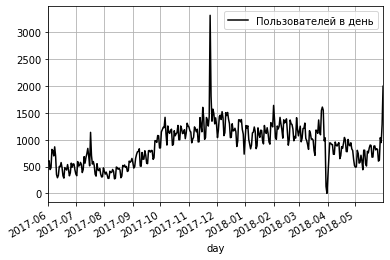

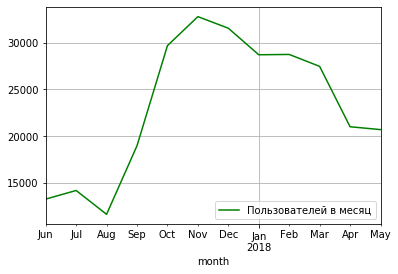

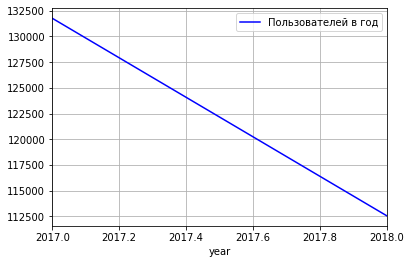

In [3]:
visits['day'] = visits['Start Ts'].astype('datetime64[D]')
visits['month'] = visits['Start Ts'].astype('datetime64[M]')
visits['year'] = visits['Start Ts'].dt.year

people_a_day = visits.pivot_table(index='day', values='Uid', aggfunc={'Uid':'nunique'}).reset_index()
people_a_month = visits.pivot_table(index='month', values='Uid', aggfunc={'Uid':'nunique'}).reset_index()
people_a_year = visits.pivot_table(index='year', values='Uid', aggfunc={'Uid':'nunique'}).reset_index()
people_a_day.plot(kind='line', x='day', y='Uid', grid=True, color=random.choice('rbgkmcy'), label='Пользователей в день')
people_a_month.plot(kind='line', x='month', y='Uid', grid=True, color=random.choice('rbgkmcy'), label='Пользователей в месяц')
people_a_year.plot(kind='line', x='year', y='Uid', grid=True, color=random.choice('rbgkmcy'), label='Пользователей в год')

Ежедневно заходит примерно стандартное количество людей. Есть всплеск в конце 2017 года. Может связано с какой-то рекламной кампанией или скидками, а может это школа организованно сходила на новогоднюю елку. Годовая тенденция ничего не говорит, либо уникальных пользователей становится меньше, либо люди меньше обращаются к данному сервису. Летом пользователи также реже пользуются афишей, скорее всего просто разъезжаются по отпускам.

###### * Сколько сессий в день?

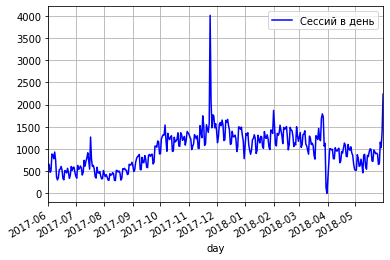

In [4]:
session_a_day = visits.pivot_table(index='day', values='Start Ts', aggfunc='count').reset_index()
session_a_day.plot(kind='line', x='day', y='Start Ts', grid=True, color=random.choice('rbgkmcy'), label='Сессий в день')

Есть 2 даты от 25.03.2018, где Start Ts > End Ts. Не убираем, т.к. на эту дату выпал переход на летнее время, исправим дальше.

###### * Сколько длится одна сессия?

In [5]:
visits['session_length'] = (visits['End Ts'] - visits['Start Ts']).dt.seconds
visits['session_length'] = visits['session_length'].where(visits['session_length'] < 83000, (visits['End Ts'] + pd.Timedelta(hours=1) - visits['Start Ts']).dt.seconds)

Не смогла подобрать функцию, где можно было бы поставить условие к значению в столбце. Поэтому, раз решила, что проблема в переводе времени, взяла значения больше 83000 (примерное кол-во секунд в сутках) и посчитала длину сессии с условием прибавки одного часа к концу сессии. Выбросов с этим условием & Start Ts <= End Ts в visits нет.

###### * Как часто люди возвращаются?

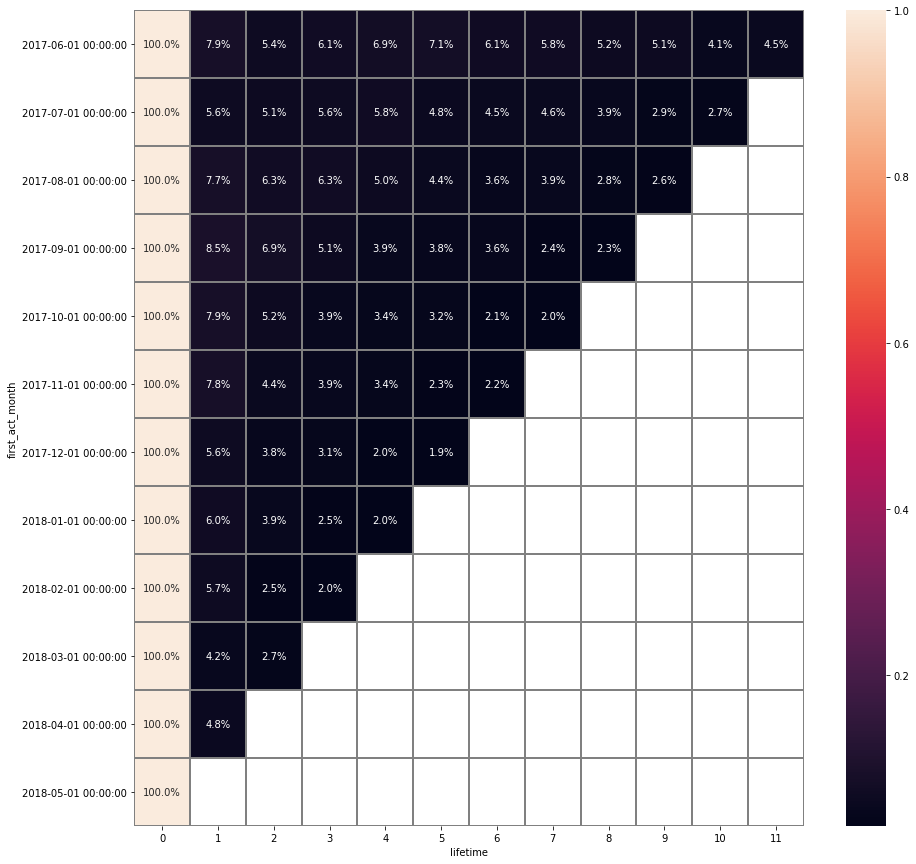

In [6]:
first_act_day = visits.groupby('Uid')['day'].min()

first_act_day.name = 'first_act_day'
visits = visits.merge(first_act_day, on='Uid')

visits['act_month'] = visits['Start Ts'].astype('datetime64[M]')
visits['first_act_month'] = visits['first_act_day'].astype('datetime64[M]')
visits['lifetime'] = ((visits['act_month'] - visits['first_act_month']) / np.timedelta64(1,'M')).round().astype('int')
cohorts = visits.groupby(['first_act_month', 'lifetime']).agg({'Uid':'nunique'}).reset_index()
users_lifetime = cohorts[cohorts['lifetime'] == 0][['first_act_month', 'Uid']]
users_lifetime = users_lifetime.rename(columns={'Uid':'cohort_users'})
cohorts = cohorts.merge(users_lifetime, on='first_act_month')
cohorts['retention'] = cohorts['Uid'] / cohorts['cohort_users']
retention = cohorts.pivot_table(index='first_act_month', columns='lifetime', values='retention')

fig = plt.subplots(figsize=(15,15))
sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, linecolor='gray', yticklabels=retention.index.round(freq = 'd'))

Люди возвращаются редко. Возможно из-за большой конкуренции на рынке. Самые первые пользователи остаются более-менее верными ресурсу. А вот новые пользователи не задерживаются.

## Продажи

###### * Когда люди начинают покупать?

In [7]:
orders['buy_month'] = orders['Buy Ts'].astype('datetime64[M]')

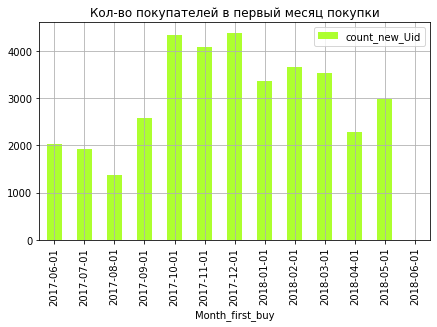

In [8]:
Month_first_buy = orders.groupby('Uid')['buy_month'].min()
Month_first_buy.name = 'Month_first_buy'

orders = orders.merge(Month_first_buy, on='Uid')
First_buy = orders.groupby('Month_first_buy')['Uid'].agg('nunique').reset_index()
First_buy.columns = ['Month_first_buy', 'count_new_Uid']
First_buy['Month_first_buy'] = First_buy['Month_first_buy'].dt.strftime('%Y-%m-%d')
First_buy.plot(kind='bar', x='Month_first_buy', title='Кол-во покупателей в первый месяц покупки', color='greenyellow', grid=True, figsize=(7,4))

Как и на первых графиках, мы видим, что лето проседает по покупкам и местами в 2 и более раза. Также проседает апрель, интересно, почему. Может просто все экономят перед майскими?

###### * Сколько раз покупают за период?

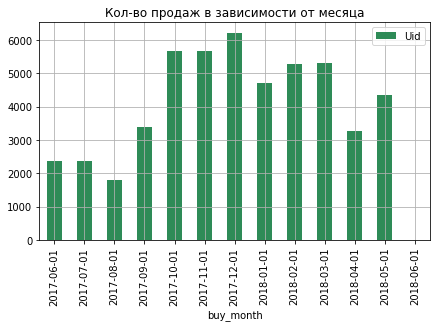

In [9]:
Time_to_buy = orders.groupby('buy_month')['Uid'].count().reset_index()
Time_to_buy['buy_month'] = Time_to_buy['buy_month'].dt.strftime('%Y-%m-%d')
Time_to_buy.plot(kind='bar', x='buy_month', title='Кол-во продаж в зависимости от месяца', color='seagreen', grid=True, figsize=(7,4))

Так и выходит: чем больше новых пользователей - тем больше покупок совершается.

###### * Какой средний чек?

In [10]:
'Средний чек: %.2f' % (orders['Revenue'].mean())

'Средний чек: 5.00'

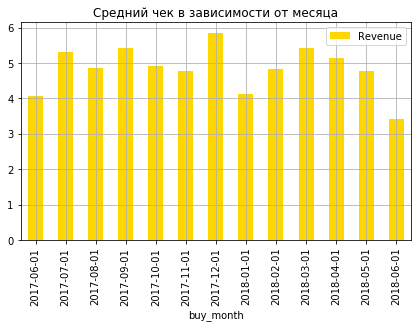

In [11]:
Mean_Revenue = orders.groupby('buy_month')['Revenue'].mean().reset_index()
Mean_Revenue['buy_month'] = Mean_Revenue['buy_month'].dt.strftime('%Y-%m-%d')
Mean_Revenue.plot(kind='bar', x='buy_month', title='Средний чек в зависимости от месяца', color='gold', grid=True, figsize=(7,4))

Средний чек колеблется около 5 предположим рублей. Декабрь получился самым дорогим. Скорее всего именно в декабре люди закупаются билетами на январь и потому он (январь) проседает на каждом графике.

###### * Сколько денег приносят? (LTV)

In [12]:
First_buy['Month_first_buy'] = First_buy['Month_first_buy'].astype('datetime64[M]')
LTV_tab = orders.merge(First_buy, on='Month_first_buy')
total = LTV_tab.groupby(['Month_first_buy', 'buy_month', 'count_new_Uid']).agg({'Revenue': 'sum'}).reset_index()

total['age'] = (total['buy_month'] - total['Month_first_buy']) / np.timedelta64(1, 'M')
total['age'] = total['age'].round().astype('int')
total['ltv'] = total['Revenue'] / total['count_new_Uid']

LTV = total.pivot_table(index='Month_first_buy', columns='age', values='ltv', aggfunc='mean').round(2).fillna('')
LTV

age,0,1,2,3,4,5,6,7,8,9,10,11
Month_first_buy,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09-01,5.64,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11-01,5.15,0.4,0.2,0.32,0.15,0.05,0.11,,,,,
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02-01,4.16,0.28,0.08,0.07,,,,,,,,


Самой прибыльной оказалась сентябрьская когорта. Уже к 7ому месяцу каждый клиент в среднем принес 13.43 рубля. На втором месте по прибыльности июнь 2017. После сентября доход с каждого покупателя начинает нелинейно падать. К декабрю все также наблюдается всплеск покупательской способности и после нового года начинает плавно затухать. 

## Маркетинг

###### * Сколько денег потратили? Всего / на каждый источник / по времени

In [13]:
Total_cost = costs['costs'].sum()
print("Потрачено всего средств на маркетинг: {:.2f}".format(Total_cost) + " руб.")

Потрачено всего средств на маркетинг: 329131.62 руб.


In [14]:
Total_cost_sourse = costs.groupby('source_id')['costs'].sum().reset_index()

for i in range(len(Total_cost_sourse)):
    j = Total_cost_sourse['costs'].values[i]
    k = Total_cost_sourse['source_id'].values[i]
    print("На {}й рекламный источник потрачено средств на маркетинг: {:.2f}".format(k, j) + " руб.")

На 1й рекламный источник потрачено средств на маркетинг: 20833.27 руб.
На 2й рекламный источник потрачено средств на маркетинг: 42806.04 руб.
На 3й рекламный источник потрачено средств на маркетинг: 141321.63 руб.
На 4й рекламный источник потрачено средств на маркетинг: 61073.60 руб.
На 5й рекламный источник потрачено средств на маркетинг: 51757.10 руб.
На 9й рекламный источник потрачено средств на маркетинг: 5517.49 руб.
На 10й рекламный источник потрачено средств на маркетинг: 5822.49 руб.


На 3тий рекламный источник потрачено больше всего средств, самые обделенные - это 9й и 10й источники.

In [15]:
costs['month'] = costs['dt'].astype('datetime64[M]')
Total_cost_month = costs.groupby('month')['costs'].sum().reset_index()
Total_cost_month['month'] = Total_cost_month['month'].dt.strftime('%Y-%m-%d')
for i in range(len(Total_cost_month)):
    j = Total_cost_month['costs'].values[i]
    k = Total_cost_month['month'].values[i]
    print("{} было потрачено средств на маркетинг: {:.2f}".format(k, j) + " руб.")

2017-06-01 было потрачено средств на маркетинг: 18015.00 руб.
2017-07-01 было потрачено средств на маркетинг: 18240.59 руб.
2017-08-01 было потрачено средств на маркетинг: 14790.54 руб.
2017-09-01 было потрачено средств на маркетинг: 24368.91 руб.
2017-10-01 было потрачено средств на маркетинг: 36322.88 руб.
2017-11-01 было потрачено средств на маркетинг: 37907.88 руб.
2017-12-01 было потрачено средств на маркетинг: 38315.35 руб.
2018-01-01 было потрачено средств на маркетинг: 33518.52 руб.
2018-02-01 было потрачено средств на маркетинг: 32723.03 руб.
2018-03-01 было потрачено средств на маркетинг: 30415.27 руб.
2018-04-01 было потрачено средств на маркетинг: 22289.38 руб.
2018-05-01 было потрачено средств на маркетинг: 22224.27 руб.


Грамотное распределение средств на маркетинг: летом - меньше, зимой - больше. Пик на предновогодние месяцы возможно и приходится потому, что на этот период распределены самые дорогие рекламные кампании.

###### * Сколько стоило привлечение одного покупателя из каждого источника?

In [16]:
costs['month'] = costs['dt'].astype('datetime64[M]')
Total_cost_month = costs.groupby(['month', 'source_id'])['costs'].sum().reset_index()
Total_cost_month.columns = ['first_act_day', 'source_id', 'costs_by_month']

visits_sourse = visits.groupby(['Uid'])['Start Ts', 'source_id'].agg({'Start Ts':'min'}).reset_index()
visits_sourse.columns = ['Uid', 'Start Ts', 'source_id']
visits_sourse['Start Ts'] = visits_sourse['Start Ts'].astype('datetime64[D]')
visits_sourse = visits_sourse.groupby(['Start Ts', 'source_id'])['Uid'].nunique().reset_index()
visits_sourse.columns = ['first_act_day', 'source_id', 'Unique_Uid']

Total_cost_month = Total_cost_month.merge(visits_sourse, on=['first_act_day', 'source_id'], how='outer')
Total_cost_month['att'] = Total_cost_month['costs_by_month'] / Total_cost_month['Unique_Uid']
cost_att_sourse = Total_cost_month.groupby('source_id')['att'].mean().reset_index().dropna().round(2)
cost_att_sourse

,source_id,att
0,1,36.99
1,2,63.14
2,3,76.78
3,4,34.44
4,5,38.57
7,9,108.79
8,10,58.68


Девятый источник стал самым дорогим для Афиши. Хорошо, что затраты на него были невелики (всего 5517.49). Третий источник, как самый затратный, неплохо справляется с привлечением, но не является самым эффективным. Стоит обратить внимание на 1йб 4й и 5й источники. При средних затратах они показывают хороший приток посетителей.

###### * На сколько окупились расходы? (ROI)

In [17]:
ROI = (orders['Revenue'].sum() - costs['costs'].sum()) / costs['costs'].sum()
print('На данный момент окупаемость рекламы составляет {:.2f}'.format(ROI))

На данный момент окупаемость рекламы составляет -0.23


Пока прибыль не окупает инвестиции.

## Отобразите на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?

###### * ROI по рекламным источникам

In [18]:
visit_orders = visits.merge(orders, on='Uid')
visit_orders = visit_orders[(visit_orders['Buy Ts'] <= visit_orders['End Ts']) & (visit_orders['Buy Ts'] >= visit_orders['Start Ts'])]

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


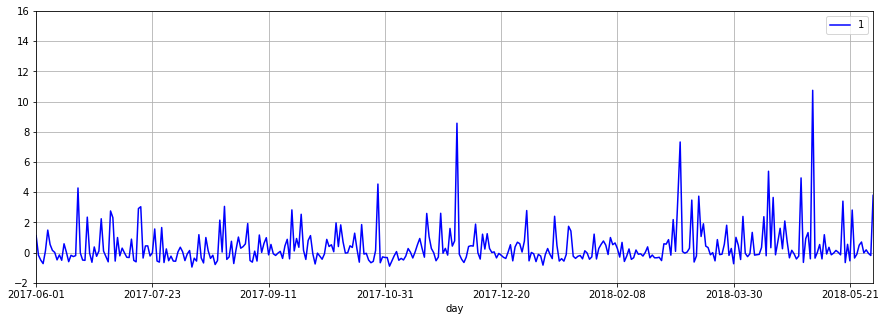

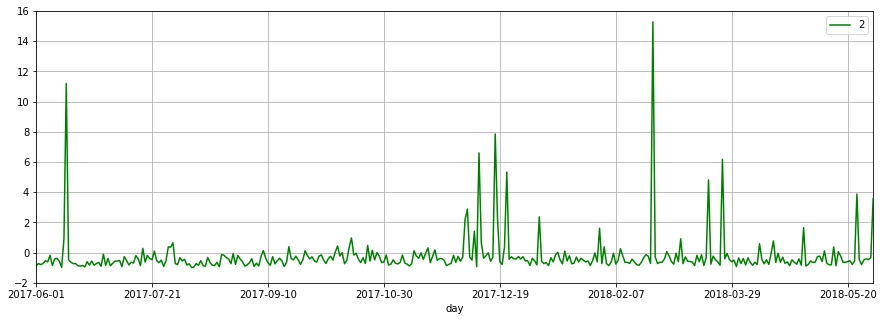

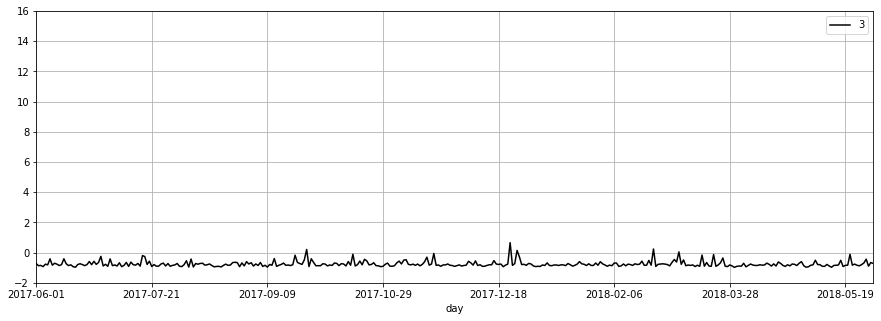

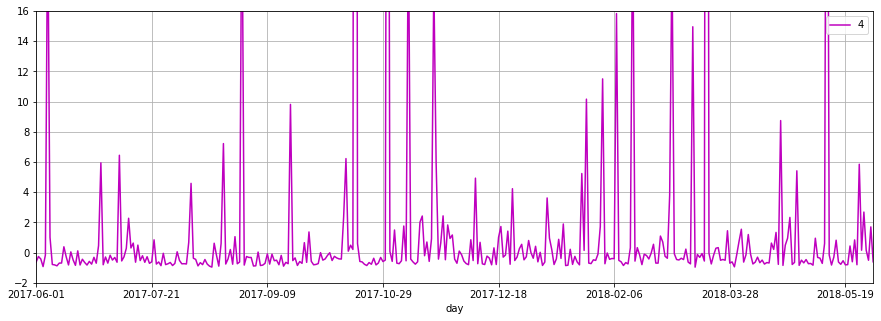

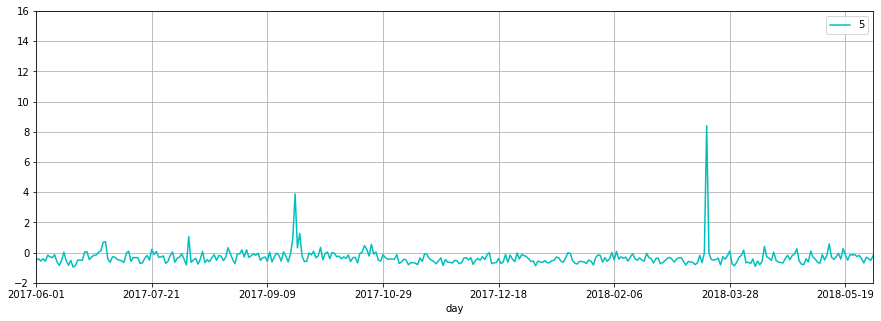

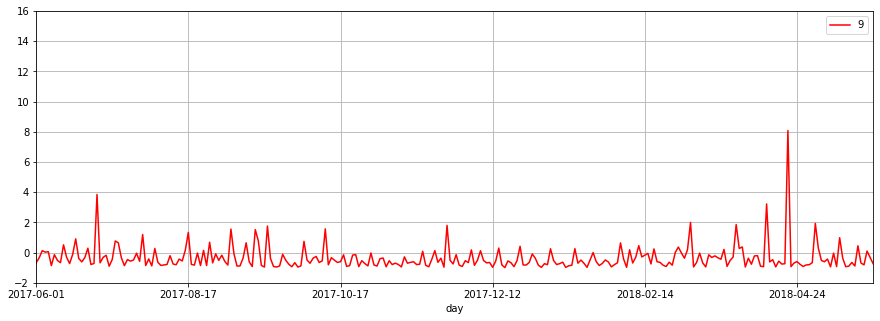

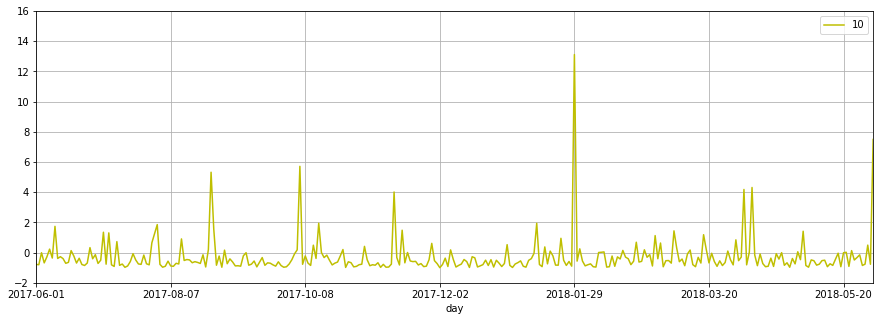

In [19]:
Revenue_day = visit_orders.groupby(['source_id', 'day'])['Revenue'].sum().reset_index()
Costs_day = costs.groupby(['source_id', 'dt'])['costs'].sum().reset_index()
Total_tab = Revenue_day.merge(Costs_day, left_on=['source_id', 'day'], right_on=['source_id', 'dt'])
Total_tab['roi'] = (Total_tab['Revenue'] - Total_tab['costs']) / Total_tab['costs']
Total_tab['day'] = Total_tab['day'].dt.strftime('%Y-%m-%d')

pivot_roi = Total_tab.groupby(['source_id','day'])['roi'].mean().reset_index()
for i in [1,2,3,4,5,9,10]:
    pivot_roi_i = pivot_roi[pivot_roi['source_id'] == i].reset_index(level=0)
    print (pivot_roi_i.plot(kind='line', x='day', y='roi', figsize=(15,5), label=i, C="rbgkmcyrwry"[i], grid=True, ylim=(-2,16)))

А вот окупаемость инвестиций в 3й и 5й источники страдает. С 3м источником были видны проблемы еще при подсчете стоимости привлечения покупателей. А вот 5й на первый взгляд неплохой, приносящий в компанию клиентов, оказалось не стимулирует этих клиентов на покупки.

###### * ROI по устройствам

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


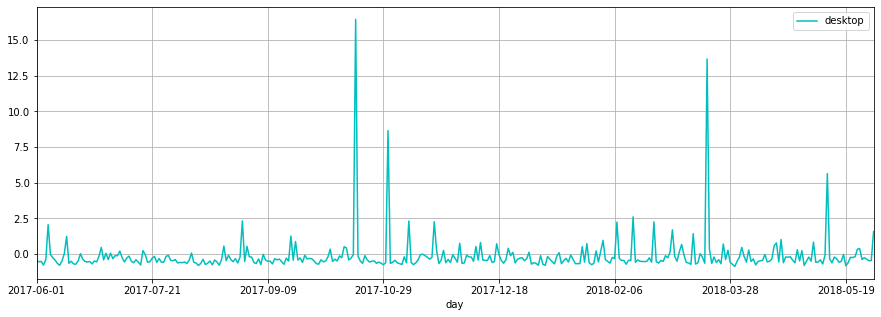

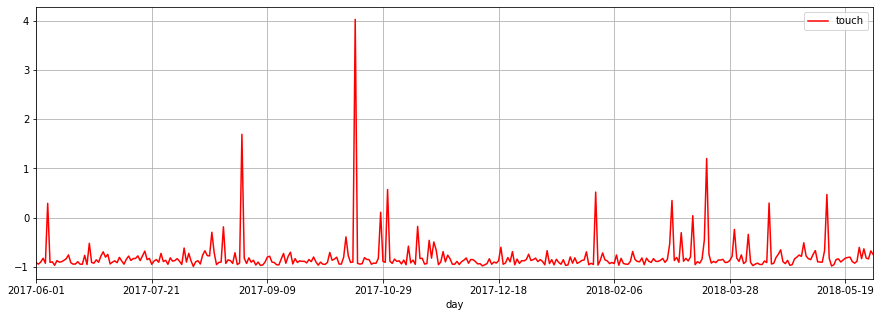

In [20]:
Revenue_day = visit_orders.groupby(['source_id', 'day', 'Device'])['Revenue'].sum().reset_index()
Costs_day = costs.groupby(['source_id', 'dt'])['costs'].sum().reset_index()
Total_tab = Revenue_day.merge(Costs_day, left_on=['source_id', 'day'], right_on=['source_id', 'dt'])
Total_tab['roi'] = (Total_tab['Revenue'] - Total_tab['costs']) / Total_tab['costs']
Total_tab['day'] = Total_tab['day'].dt.strftime('%Y-%m-%d')

pivot_roi = Total_tab.groupby(['Device','day'])['roi'].mean().reset_index()
for i in pivot_roi['Device'].unique():
    pivot_roi_i = pivot_roi[pivot_roi['Device'] == i].reset_index(level=0)
    print (pivot_roi_i.plot(kind='line', x='day', y='roi', figsize=(15,5), label=i, grid=True, C=random.choice('rbgkmcyrry')))

У заказов с телефонов явные проблемы. Окупаемость рекламы практически всегда в отрицательных значениях. Возможно неудобное приложение, может неактивная реклама.

###### * LTV по источникам

In [21]:
def ltv(data):
    visit_orders_i = visit_orders[visit_orders['source_id'] == data]
    Month_first_buy = visit_orders_i.groupby('Uid')['buy_month'].min()
    Month_first_buy.name = 'Month_first'

    visit_orders_i = visit_orders_i.merge(Month_first_buy, on='Uid')
    First_buy = visit_orders_i.groupby('Month_first')['Uid'].agg('nunique').reset_index()
    First_buy.columns = ['Month_first', 'count_new_Uid']
    First_buy['Month_first'] = First_buy['Month_first'].dt.strftime('%Y-%m-%d')
    First_buy['Month_first'] = First_buy['Month_first'].astype('datetime64[M]')
    LTV_tab = visit_orders_i.merge(First_buy, on='Month_first')
    total = LTV_tab.groupby(['Month_first', 'buy_month', 'count_new_Uid']).agg({'Revenue': 'sum'}).reset_index()

    total['age'] = (total['buy_month'] - total['Month_first']) / np.timedelta64(1, 'M')
    total['age'] = total['age'].round().astype('int')
    total['ltv'] = total['Revenue'] / total['count_new_Uid']

    LTV = total.pivot_table(index='Month_first', columns='age', values='ltv', aggfunc='mean').round(2).fillna('')
    LTV
    return LTV
print('Рекламный источник {}'.format(visit_orders['source_id'].unique()[3]))
ltv(visit_orders['source_id'].unique()[3])

Рекламный источник 1


age,0,1,2,3,4,5,6,7,8,9,10,11
Month_first,,,,,,,,,,,,
2017-06-01,4.85,0.1,0.21,0.31,0.28,0.78,2.14,0.2,0.4,1.4,1.06,0.16
2017-07-01,6.77,0.25,0.89,0.16,0.07,0.2,0.05,0.1,0.36,0.44,0.08,
2017-08-01,5.74,0.91,0.3,0.26,0.24,0.23,0.25,0.85,0.2,0.14,,
2017-09-01,5.63,0.13,0.38,0.25,0.5,0.03,0.01,0.25,0.02,,,
2017-10-01,5.80,0.37,0.13,0.06,0.13,0.75,0.02,0.06,,,,
2017-11-01,5.63,0.4,0.12,0.17,0.08,0.18,0.38,,,,,
2017-12-01,3.97,0.11,0.16,0.26,0.07,0.03,,,,,,
2018-01-01,4.57,0.52,0.04,0.36,0.05,,,,,,,
2018-02-01,4.37,0.9,0.04,0.01,,,,,,,,


In [22]:
print('Рекламный источник {}'.format(visit_orders['source_id'].unique()[2]))
ltv(visit_orders['source_id'].unique()[2])

Рекламный источник 2


age,0,1,2,3,4,5,6,7,8,9,10,11
Month_first,,,,,,,,,,,,
2017-06-01,5.84,0.18,0.06,0.35,0.17,0.1,0.16,0.12,0.08,0.1,0.01,0.07
2017-07-01,6.59,0.61,0.18,0.35,0.18,0.66,0.27,0.18,0.2,0.04,0.13,
2017-08-01,4.69,1.09,0.36,0.27,0.27,0.1,0.15,0.09,0.01,0.7,,
2017-09-01,5.46,3.37,0.47,0.31,0.87,0.42,1.25,0.07,0.15,,,
2017-10-01,6.16,0.48,0.05,0.28,0.01,0.05,0.02,0.14,,,,
2017-11-01,5.49,9.64,1.04,1.21,0.12,0.2,0.07,,,,,
2017-12-01,7.73,1.12,3.22,3.57,0.24,0.05,,,,,,
2018-01-01,4.30,0.32,0.43,0.2,0.04,,,,,,,
2018-02-01,4.15,0.13,0.08,0,,,,,,,,


In [23]:
print('Рекламный источник {}'.format(visit_orders['source_id'].unique()[1]))
ltv(visit_orders['source_id'].unique()[1])

Рекламный источник 3


age,0,1,2,3,4,5,6,7,8,9,10,11
Month_first,,,,,,,,,,,,
2017-06-01,3.10,,,,0.02,,0,,0.01,,0.01,0
2017-07-01,4.92,0.02,0.01,0.01,,0,0.01,0.1,0.01,0.01,0.01,
2017-08-01,4.70,,0.07,,0,,0.01,0.02,0.01,,,
2017-09-01,5.06,0.01,0.01,0.06,0.04,,0.06,,0.07,,,
2017-10-01,3.88,0.03,0.02,0,0,0,,0.03,,,,
2017-11-01,4.30,0.04,0.02,0.01,0,,0.01,,,,,
2017-12-01,3.79,0,0.03,0,0,0,,,,,,
2018-01-01,3.68,0.01,0.01,0.01,0,,,,,,,
2018-02-01,3.54,0,0.02,,,,,,,,,


In [24]:
print('Рекламный источник {}'.format(visit_orders['source_id'].unique()[0]))
ltv(visit_orders['source_id'].unique()[0])

Рекламный источник 4


age,0,1,2,3,4,5,6,7,8,10,11
Month_first,,,,,,,,,,,
2017-06-01,4.15,0,,0.01,0.05,0.01,0.01,,0.01,0.07,0.05
2017-07-01,5.12,0.01,0.05,0.1,0.01,0.03,0,0.04,0.05,,
2017-08-01,4.61,0.06,0.11,0.03,0.04,0.01,0.07,0.01,0.02,,
2017-09-01,3.82,0.05,0.09,0.01,0.01,0.06,0.03,0.02,0,,
2017-10-01,4.19,0.09,0.06,0.01,0.01,0.01,0.01,,,,
2017-11-01,4.25,0.02,0.02,0.03,0,0.01,0.01,,,,
2017-12-01,3.82,0.05,0.08,0.09,0,0.04,,,,,
2018-01-01,3.58,0.06,,,,,,,,,
2018-02-01,3.67,0.04,,0,,,,,,,


In [25]:
print('Рекламный источник {}'.format(visit_orders['source_id'].unique()[5]))
ltv(visit_orders['source_id'].unique()[5])

Рекламный источник 5


age,0,1,2,3,4,5,6,7,8,9,10,11
Month_first,,,,,,,,,,,,
2017-06-01,4.64,0.24,0.11,0.72,0.38,0.36,0.3,0.39,0.16,0.28,0.09,0.01
2017-07-01,4.75,0.32,0.22,0.1,0.08,0.12,0.03,0.13,0.06,0.03,0.05,
2017-08-01,4.59,0.05,0.17,0.03,0.04,0.08,0.01,,0.02,,,
2017-09-01,5.88,0.13,0.16,0.22,0.06,0.15,0.08,0.03,0.07,,,
2017-10-01,4.89,0.02,0.04,0.03,0.04,0.01,0.01,0.04,,,,
2017-11-01,4.37,0.01,0.03,0.01,0.02,0,0.06,,,,,
2017-12-01,4.52,0.02,0.05,0.01,0.01,0,,,,,,
2018-01-01,3.86,0.22,0.06,0.01,0.13,,,,,,,
2018-02-01,4.16,0.1,0.11,0.04,,,,,,,,


In [26]:
print('Рекламный источник {}'.format(visit_orders['source_id'].unique()[7]))
ltv(visit_orders['source_id'].unique()[7])

Рекламный источник 7


age,0
Month_first,
2017-08-01,1.22


In [27]:
print('Рекламный источник {}'.format(visit_orders['source_id'].unique()[4]))
ltv(visit_orders['source_id'].unique()[4])

Рекламный источник 9


age,0,1,2,3,4,5,6,8,9,10
Month_first,,,,,,,,,,
2017-06-01,2.89,,,0.07,,0.08,,0.1,0.05,0.12
2017-07-01,4.16,0.06,0.15,,0.05,0,0.37,,,
2017-08-01,2.62,,,,,0.05,,,,
2017-09-01,4.31,0.04,0.04,,0,,,,,
2017-10-01,3.33,,,0.04,0,,,,,
2017-11-01,3.18,,0.02,0.07,0.02,,,,,
2017-12-01,3.38,0.05,,0.23,,0.09,,,,
2018-01-01,2.27,0.11,0.03,,,,,,,
2018-02-01,4.43,,,,,,,,,


In [28]:
print('Рекламный источник {}'.format(visit_orders['source_id'].unique()[6]))
ltv(visit_orders['source_id'].unique()[6])

Рекламный источник 10


age,0,1,3,4,5,6
Month_first,,,,,,
2017-06-01,2.00,,,,,
2017-07-01,2.67,,,,,
2017-08-01,4.93,,,,,
2017-09-01,2.04,,,,,
2017-10-01,2.46,,0.02,0,,
2017-11-01,3.72,0.03,,,0.01,0.02
2017-12-01,3.20,,,,,
2018-01-01,2.99,0.01,,,,
2018-02-01,2.46,,,,,


Выстроены LTV по порядку рекламных источников. 7, 9 и 10 источники приносят компании наименьшую прибыль с привлеченных клиентов. 5й источник хоть и приносит хорошую прибыль, но по окупаемости себя не вытягивает. 

###### * LTV по устройствам

In [29]:
def ltv(data):
    visit_orders_i = visit_orders[visit_orders['Device'] == data]
    Month_first_buy = visit_orders_i.groupby('Uid')['buy_month'].min()
    Month_first_buy.name = 'Month_first'

    visit_orders_i = visit_orders_i.merge(Month_first_buy, on='Uid')
    First_buy = visit_orders_i.groupby('Month_first')['Uid'].agg('nunique').reset_index()
    First_buy.columns = ['Month_first', 'count_new_Uid']
    First_buy['Month_first'] = First_buy['Month_first'].dt.strftime('%Y-%m-%d')
    First_buy['Month_first'] = First_buy['Month_first'].astype('datetime64[M]')
    LTV_tab = visit_orders_i.merge(First_buy, on='Month_first')
    total = LTV_tab.groupby(['Month_first', 'buy_month', 'count_new_Uid']).agg({'Revenue': 'sum'}).reset_index()

    total['age'] = (total['buy_month'] - total['Month_first']) / np.timedelta64(1, 'M')
    total['age'] = total['age'].round().astype('int')
    total['ltv'] = total['Revenue'] / total['count_new_Uid']

    LTV = total.pivot_table(index='Month_first', columns='age', values='ltv', aggfunc='mean').round(2).fillna('')
    LTV
    return LTV
print(visit_orders['Device'].unique()[0])
ltv(visit_orders['Device'].unique()[0])   

desktop


age,0,1,2,3,4,5,6,7,8,9,10,11
Month_first,,,,,,,,,,,,
2017-06-01,4.43,0.2,0.21,0.43,0.38,0.38,0.68,0.28,0.29,0.46,0.34,0.08
2017-07-01,5.59,0.17,0.4,0.2,0.07,0.1,0.05,0.03,0.09,0.12,0.1,
2017-08-01,4.90,0.19,0.15,0.14,0.11,0.09,0.05,0.27,0.14,0.12,,
2017-09-01,5.40,0.53,0.26,2.56,0.47,0.4,0.32,0.13,0.11,,,
2017-10-01,4.79,0.27,0.1,0.08,0.06,0.15,0.03,0.06,,,,
2017-11-01,4.57,0.2,0.13,0.11,0.03,0.02,0.11,,,,,
2017-12-01,4.68,0.25,0.61,0.95,0.07,0.08,,,,,,
2018-01-01,3.98,0.25,0.19,0.15,0.04,,,,,,,
2018-02-01,4.00,0.12,0.05,0.03,,,,,,,,


In [30]:
print(visit_orders['Device'].unique()[1])
ltv(visit_orders['Device'].unique()[1])

touch


age,0,1,2,3,4,5,6,7,8,9,10,11
Month_first,,,,,,,,,,,,
2017-06-01,3.23,0.03,0.08,0.02,0.01,0.03,,,,,,0.02
2017-07-01,4.88,0.04,0.01,0.02,0.03,0.02,0,0.02,0.01,,0.07,
2017-08-01,4.36,0.05,0.1,0,,0.01,0.08,0.01,0.01,0.05,,
2017-09-01,3.91,0.71,0.27,0.15,0.01,0.02,0.01,,0,,,
2017-10-01,4.31,0.36,0.06,0,0.02,0.11,0.01,0,,,,
2017-11-01,4.98,0.04,0.03,0.04,0.03,0.01,0.01,,,,,
2017-12-01,3.56,0.05,0.1,0.14,0.01,0,,,,,,
2018-01-01,3.39,0.06,0.01,0,,,,,,,,
2018-02-01,3.40,0.03,0,,,,,,,,,


Десктоп определенно перетягивает на себя посетителей сайта. Больше прибыли приносит и лучше окупает инвестиции в себя.

### Вывод:

Люди редко возвращаются в Афишу. Есть смысл вкладываться в 1й и 4й рекламные источники. Они показывают неплохой уровень привлечения покупателей. Инвестиции в десктопную версию продукта ощутимо выгоднее, чем в приложение.